# Long Short Term Memory (LSTM) Networks

### Import necessary libraries

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split    
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score
import joblib

### Load data

In [22]:
data_path = r"C:\Users\ADMIN\Desktop\Stock-Price-Forecasting-System-Using-Apache-Spark\data\processed\data.csv"
df = pd.read_csv(data_path)
df = df.sort_values(by="Date")
df.head()

,Date,Open,High,Low,Close,Volume,Price_Range,Daily_Change,MA_10,MA_50,RSI,Upper_BB,Lower_BB,Stoch_Osc,Target
0,2018-02-07,266.579987,272.450012,264.329987,264.559998,8981500,8.120025,-2.019989,261.513331,261.513331,90.808224,274.129918,248.896744,71.964741,250.100006
1,2018-02-08,267.079987,267.619995,250.000000,250.100006,9306700,17.619995,-16.979981,258.660000,258.660000,42.319075,274.034747,243.285253,-13.719122,249.470001
2,2018-02-09,253.850006,255.800003,236.110001,249.470001,16906900,19.690002,-4.380005,256.822000,256.822000,41.356924,272.469748,241.174253,2.211785,257.950012
3,2018-02-12,252.139999,259.149994,249.000000,257.950012,8534900,10.149994,5.810013,257.010002,257.010002,55.098114,271.036045,242.983960,55.943323,258.269989
4,2018-02-13,257.290009,261.410004,254.699997,258.269989,6855200,6.710007,0.979980,257.190000,257.190000,55.491639,270.029344,244.350657,57.647675,266.000000


# Data Preprocessing

In [23]:
# Data type conversion
dataset = pd.DataFrame(df.reset_index()["Close"])
data = dataset.values
data = data.astype('float32')

In [24]:
import os 
os.makedirs('../model', exist_ok=True)
# Data normalization

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
joblib.dump(scaler, '../model/scaler.pkl')

['../model/scaler.pkl']

In [25]:
train_size = int(len(data)*0.8)
test_size = len(data)-train_size 
train, test = data[0:train_size,:], data[train_size:len(data),:] 
print(f"Train Size: {len(train)}")
print(f"Test Size: {len(test)}")

Train Size: 804
Test Size: 202


### Create sequences with step back

In [26]:
# function to take 
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
     a = dataset[i:(i+look_back), 0]
     dataX.append(a)
     dataY.append(dataset[i + look_back, 0])
 return np.array(dataX), np.array(dataY)

# train and test set
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back) 

# reshape the X and y data
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(802, 1, 1) (802,) (200, 1, 1) (200,)


### Load data to GPU

In [ ]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
a
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainX = torch.tensor(trainX, dtype=torch.float32).to(device)
trainY = torch.tensor(trainY, dtype=torch.float32).to(device)
testX = torch.tensor(testX, dtype=torch.float32).to(device)
testY = torch.tensor(testY, dtype=torch.float32).to(device)

CUDA available: True
CUDA version: 12.1


# Model building

In [28]:
# Set the seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
# Define the LSTM Model
class SequentialLSTM(nn.Module):
    def __init__(self, input_size, output_size):
        super(SequentialLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, 128, batch_first=True)
        self.lstm2 = nn.LSTM(128, 64, batch_first=True)
        self.lstm3 = nn.LSTM(64, 32, batch_first=True)
        self.fc1 = nn.Linear(32, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, output_size)
    
    def forward(self, x):
        # LSTM1
        x, _ = self.lstm1(x) 
        
        # LSTM2
        x, _ = self.lstm2(x)  
        # LSTM3
        x, _ = self.lstm3(x)
        
        # Fully connected layers
        x = self.relu(self.fc1(x[:, -1, :]))  
        x = self.fc2(x)
        return x

In [29]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model
input_size = trainX.shape[2]  # Number of features in input
output_size = 1
model = SequentialLSTM(input_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Convert training data to PyTorch tensors and move to the device
    trainX_tensor = torch.tensor(trainX, dtype=torch.float32).to(device)
    trainY_tensor = torch.tensor(trainY, dtype=torch.float32).unsqueeze(1).to(device)
    
    # Forward pass
    outputs = model(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [10/200], Loss: 0.1534


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_30440\1593840310.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainX_tensor = torch.tensor(trainX, dtype=torch.float32).to(device)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_30440\1593840310.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainY_tensor = torch.tensor(trainY, dtype=torch.float32).unsqueeze(1).to(device)


Epoch [20/200], Loss: 0.1234
Epoch [30/200], Loss: 0.0865
Epoch [40/200], Loss: 0.0410
Epoch [50/200], Loss: 0.0350
Epoch [60/200], Loss: 0.0288
Epoch [70/200], Loss: 0.0283
Epoch [80/200], Loss: 0.0259
Epoch [90/200], Loss: 0.0239
Epoch [100/200], Loss: 0.0213
Epoch [110/200], Loss: 0.0180
Epoch [120/200], Loss: 0.0140
Epoch [130/200], Loss: 0.0092
Epoch [140/200], Loss: 0.0046
Epoch [150/200], Loss: 0.0016
Epoch [160/200], Loss: 0.0009
Epoch [170/200], Loss: 0.0010
Epoch [180/200], Loss: 0.0009
Epoch [190/200], Loss: 0.0009
Epoch [200/200], Loss: 0.0008


In [30]:
# Predictions
model.eval()
trainPredict = model(trainX).detach().cpu().numpy()
testPredict = model(testX).detach().cpu().numpy()

# Inverse transform predictions and actual values
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY.cpu().numpy().reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY.cpu().numpy().reshape(-1, 1))

# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 12.91 RMSE
Test Score: 14.29 RMSE


In [31]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(data) - 1, :] = testPredict    

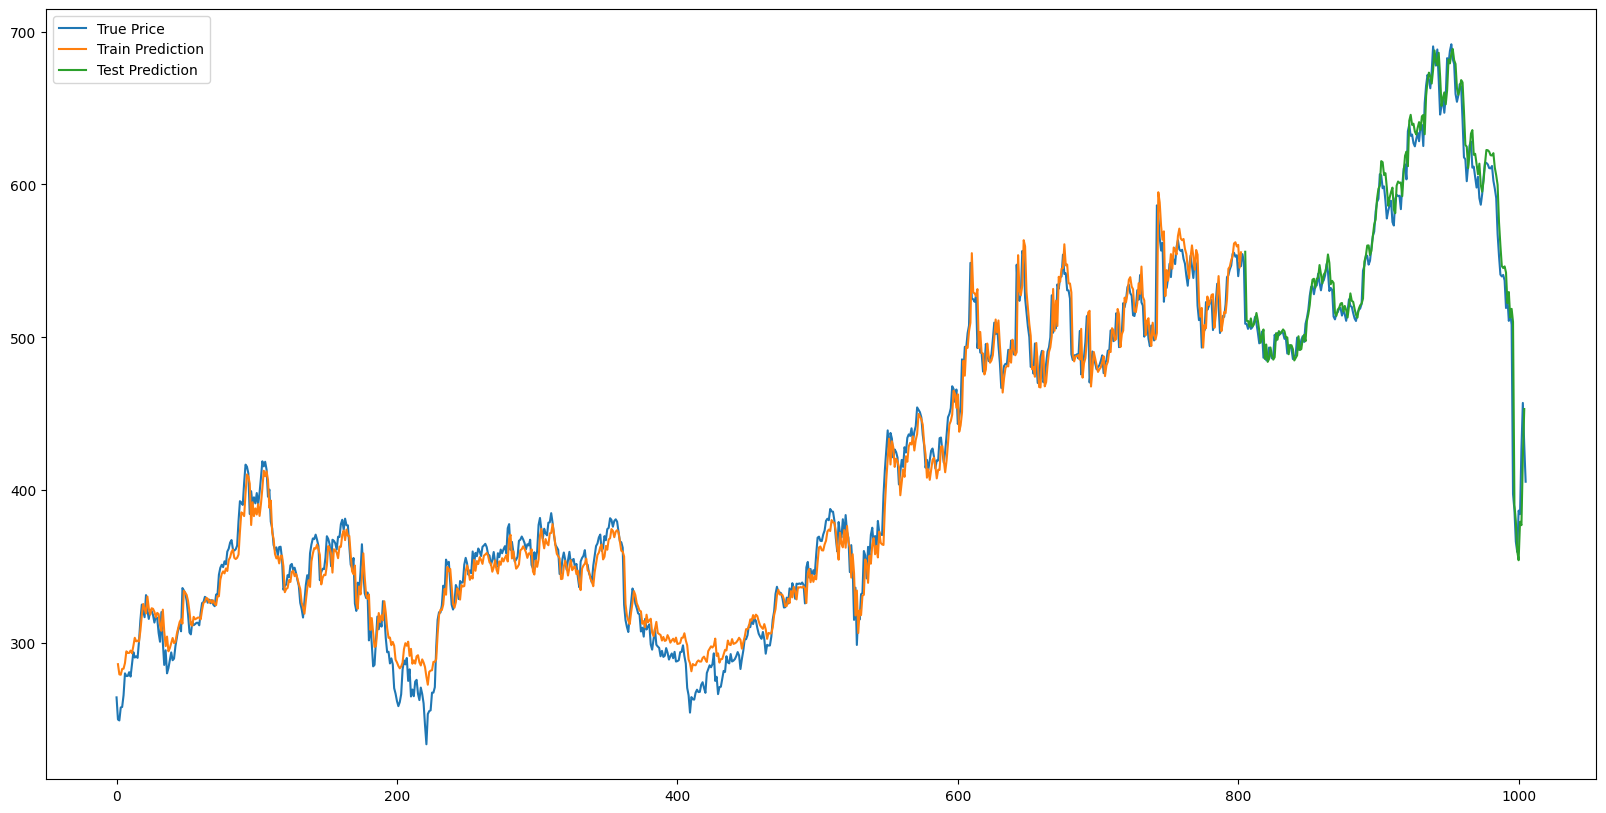

In [32]:
# plot the date, close price and the close price predictions
plt.figure(figsize=(20, 10))
plt.plot(scaler.inverse_transform(data), label='True Price')
plt.plot(trainPredictPlot, label='Train Prediction')
plt.plot(testPredictPlot, label='Test Prediction')
plt.legend()
plt.show()

In [33]:
# save the model
torch.save(model.state_dict(), "../model/lstm.pth")

In [34]:
test = pd.read_csv('../data/processed/test.csv')
test.head()

,Date,Open,High,Low,Close,Volume,Price_Range,Daily_Change,MA_10,MA_50,RSI,Upper_BB,Lower_BB,Stoch_Osc
0,2021-04-23,509.010010,509.700012,500.700012,505.549988,7307700,9.000000,-3.460022,536.952997,531.958602,32.527344,573.092331,497.715665,-264.999153
1,2021-04-26,506.760010,510.480011,503.000000,510.299988,4388800,7.480011,3.539978,532.704993,531.012802,33.119589,572.873005,498.159991,-201.777501
2,2021-04-27,512.619995,512.989990,504.579987,505.549988,3761300,8.410003,-7.070007,527.886993,529.993401,30.015406,573.643846,496.549147,-220.614508
3,2021-04-28,505.200012,508.399994,503.339996,506.519989,3193000,5.059998,1.319977,524.536990,528.978200,25.242064,574.226109,495.279882,-188.498135
4,2021-04-29,507.600006,509.290009,499.000000,509.000000,5127800,10.290009,1.399994,520.514993,528.131400,26.566108,574.862778,493.377215,-133.081992


In [35]:
test.dtypes

Date             object
Open            float64
High            float64
Low             float64
Close           float64
Volume            int64
Price_Range     float64
Daily_Change    float64
MA_10           float64
MA_50           float64
RSI             float64
Upper_BB        float64
Lower_BB        float64
Stoch_Osc       float64
dtype: object

In [36]:
model = SequentialLSTM(input_size=1, output_size=1)  # Ensure input and output sizes match your saved model
model.load_state_dict(torch.load("../model/lstm.pth"))
model.eval()
model.to(device)

SequentialLSTM(
  (lstm1): LSTM(1, 128, batch_first=True)
  (lstm2): LSTM(128, 64, batch_first=True)
  (lstm3): LSTM(64, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)

In [37]:
# Load the new CSV file
new_df = pd.read_csv('../data/processed/test.csv')  # Replace with your new CSV file path
new_df = new_df.sort_values(by="Date")  # Ensure it's sorted by Date

# Extract and scale the 'Close' values
new_data = new_df[['Close']].values.astype('float32')
new_data = scaler.transform(new_data)  # Use the same scaler for consistency

# Create the dataset with look_back
newX, _ = create_dataset(new_data, look_back)
newX = np.reshape(newX, (newX.shape[0], 1, newX.shape[1]))

# Convert to tensor
newX = torch.tensor(newX, dtype=torch.float32).to(device)


In [38]:
# Predict with the model
newPredictions = model(newX).detach().cpu().numpy()

# Inverse transform the predictions
newPredictions = scaler.inverse_transform(newPredictions)


In [39]:
# Adjust the Date column to match the prediction dataset
dates = new_df['Date'][look_back:len(newPredictions) + look_back].reset_index(drop=True)

# Create a DataFrame
results_df = pd.DataFrame({
    'Date': dates,
    'Actual': new_df['Close'][look_back:len(newPredictions) + look_back].reset_index(drop=True),
    'Predicted': newPredictions.flatten()
})

# Display the DataFrame
print(results_df.head())




         Date      Actual   Predicted
0  2021-04-26  510.299988  507.076874
1  2021-04-27  505.549988  512.408142
2  2021-04-28  506.519989  507.076874
3  2021-04-29  509.000000  508.167786
4  2021-04-30  513.469971  510.955872


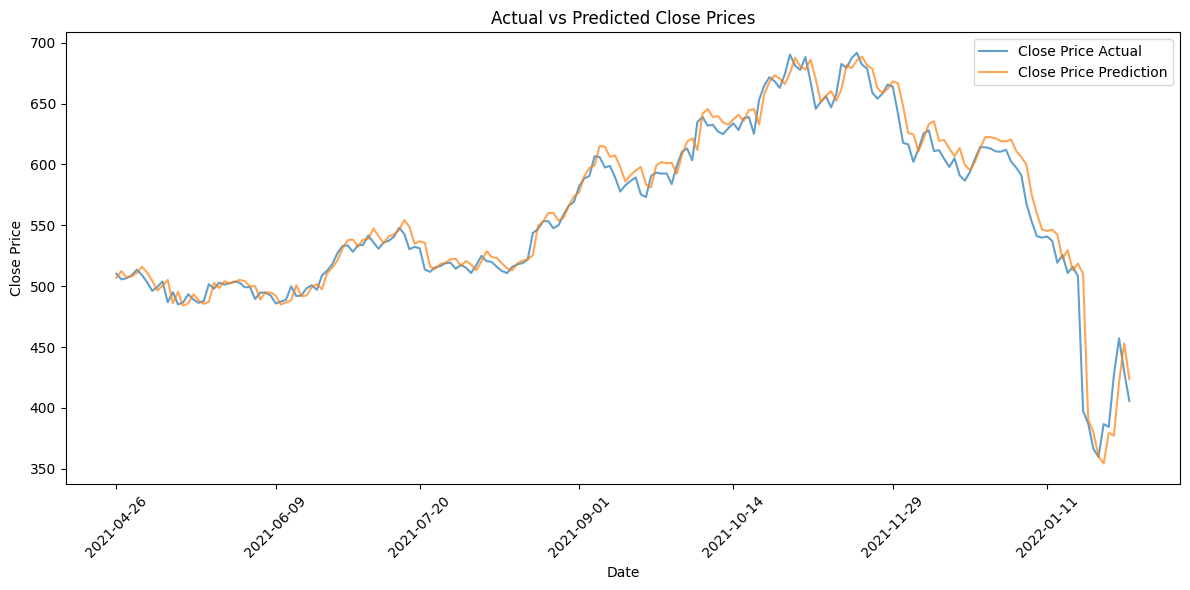

In [40]:
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Close Price Actual', alpha=0.7)
plt.plot(results_df['Date'], results_df['Predicted'], label='Close Price Prediction', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.tight_layout()
plt.show()